In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'test.csv', 'class.csv', 'sample_submission.csv']


제가 올리는 코드는 마음것 이용하셔도 됩니다.
올라온 Weight들 가져다 쓰셔도 좋습니다. 

다만 조금이라도 도움이 되셨다면,이용하실때 출처 밝혀주시고, 투표 한번 해주세요. 작성하신 Kernel 공개, 또는 Discussion에서 같이 공유하고 더 나은 방법이 있는지 같이 고민했으면 좋겠습니다. 

제가 한 결과를 공유 드리는 이유는 전 이론에 대해서 약합니다. 해서 제 공개된 커널로 다른 분들의 도움을 받고 싶어서입니다.

keras 사용법, 함수 사용법에 익숙하시지 않으신 분들에게 조금이라도 도움이 되셨으면 하는 마음도 있습니다.
(그렇다고 제가 올린 Kernel이 아주 나이스한 문법이라는 뜻 아닙니다.)

단순 복사에 Leader보드 등록만 하시는 분들은 없으실 거라 믿습니다.

하기 Kernel 내용을 요약하면
1. Xception 사전 훈련 모델을 사용
2. StratifiedKFold로 5 Fold로 나눠서 훈련 및 검증 수행
3. 각 Fold 마다 val_loss가 가작 작게 나온 것에 대해서 Weight 파일로 저장
4. 훈련에서 나온 5개의 Weight로 예측 진행
5. 5개의 예측결과 평균(앙상블)

추가로 StratifiedKFold와 Keras의 ImageDataGenerator()를 같이 운영했습니다.

In [2]:
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
from sklearn.model_selection import StratifiedKFold, KFold

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import Xception

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
warnings.filterwarnings('ignore')
K.image_data_format()

'channels_last'

In [4]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 100
k_folds=5

* IMAGE_SIZE는 사용하는 사전훈련 모델별 추천하는 이미지 사이즈를 주기 위해서입니다.

Xception의 경우 299 * 299임.

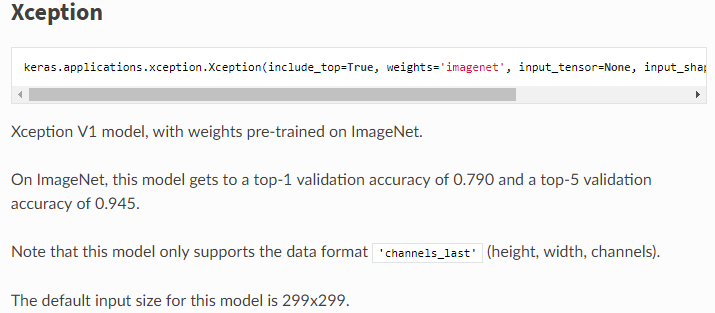

* BATCH_SIZE 를 4로 한 이유는 제 PC에서 이보다 크게 주면 자원 부족으로 모델 훈련 진행이 불가함. 자원 되시는 분들으 Batch 사이즈 늘려 잡으시면 훈련시간 단축이 가능합니다.

* EPOCHS 는 100로 주었지만 EarlyStoping 함수와 같이 사용하기 때문에 실제로 대략 30Epoch 이하에서 Fold별 훈련이 중단 됩니다.

* Folds는 5개로 한 이유는 이렇게 하여 매 Fold당 검증 데이터 20% 맞추려는 의도 입니다.

In [5]:
DATA_PATH = '../input'

In [6]:
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

In [7]:
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [8]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


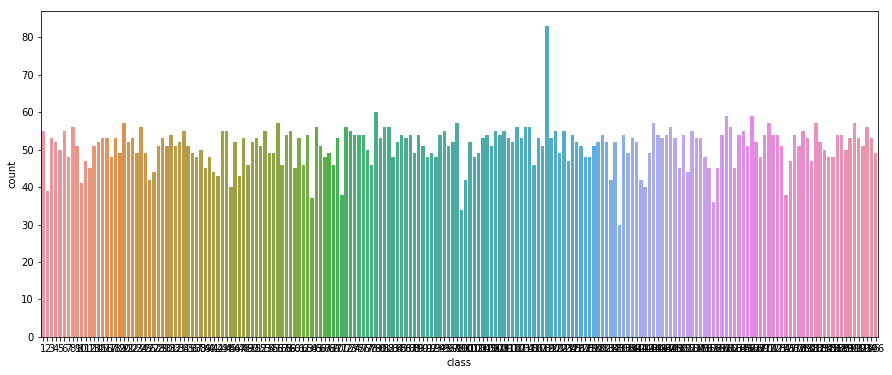

In [9]:
plt.figure(figsize=(15,6))
sns.countplot('class', data=df_train)
plt.show()

In [10]:
df_train['class'].value_counts()

119    83
79     60
161    59
167    59
20     57
       ..
175    38
64     37
158    36
99     34
136    30
Name: class, Length: 196, dtype: int64

119번 유형이 84개로 제일 많고,

136번 유형이 30개로 가장 적음.

In [11]:
df_train['class'].value_counts().mean()

50.96938775510204

각 차종별 평균 분포개수는 51개임.

In [12]:
df_train['class'].value_counts().describe()

count    196.000000
mean      50.969388
std        5.374115
min       30.000000
25%       48.000000
50%       52.000000
75%       54.000000
max       83.000000
Name: class, dtype: float64

위의 내용을 요약하여 출력해 보면,
최대값 84, 최소값 30, 평균51로 편차가 좀 있다고 볼 수도 있습니다.
그래서 KFold대신 StratifiedKFold를 사용하였습니다.

In [13]:
def crop_boxing_img(img_name, margin=-4, size=(IMAGE_SIZE,IMAGE_SIZE)):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        PATH = TEST_IMG_PATH
        data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1, y1, x2, y2)).resize(size)

crop_boxing은 

 [Daehun Gwak님 커널](https://www.kaggle.com/daehungwak/keras-how-to-use-pretrained-model)

 [허태명님 커널](https://www.kaggle.com/tmheo74/3rd-ml-month-car-image-cropping)
 
 에서 가져왔습니다.

In [14]:
TRAIN_CROPPED_PATH = '../cropped_train'
TEST_CROPPED_PATH = '../cropped_test'

In [ ]:
if (os.path.isdir(TRAIN_CROPPED_PATH) == False):
    os.mkdir(TRAIN_CROPPED_PATH)

if (os.path.isdir(TEST_CROPPED_PATH) == False):
    os.mkdir(TEST_CROPPED_PATH)

for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(os.path.join(TRAIN_CROPPED_PATH, row['img_file']))

for i, row in df_test.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(os.path.join(TEST_CROPPED_PATH, row['img_file']))

Cropping한 이미지 저장하기 위한 디렉토리 생성및 Cropping

In [ ]:
df_train['class'] = df_train['class'].astype('str')
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

In [ ]:
model_path = './'

In [ ]:
def get_callback(model_name, patient):
    ES = EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    MC = ModelCheckpoint(
        filepath=model_name, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='min')

    return [ES, RR, MC]

* EarlyStoping은 인자인 Patient가 10으로 들어온다면, Val_loss가 10회 이상 좋아지지 않으면 Stop.
* ReduceLROnPlateau는 Patient/2 회만큼 Val_loss가 좋아지지 않으면 learing late를 반으로 줄이는 용도.
* ModelCheckPoint는 Val_loss가 가장 좋은(가장작은) 경우에 해당 훈련 Weight 파일로 저장.

PC자원이 되시는 분들 여기에 Tensorboard도 추가하시면 실시간 훈련 그래프를 확인해 보실 수 있습니다.

In [ ]:
def get_model(model_name, iamge_size):
    base_model = model_name(weights='imagenet', input_shape=(iamge_size,iamge_size,3), include_top=False)
    #base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.25))
 
    model.add(layers.Dense(196, activation='softmax'))
    model.summary()

    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model

사전 훈련모델인 Xception에 층을 더해서 훈련 시키는 구조로 모델을 구성하였습니다.
Dropout은 과적합을 최대한 줄여볼 용도로 추가했습니다. (0.5)면 반을 날려 버린다는 의미입니다.
타노스의 손가락 튕기기

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    shear_range=0.3,
    #brightness_range=(1, 1.2),
    fill_mode='nearest'
    )

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True  # divide each input by its std
    )
test_datagen = ImageDataGenerator(
    rescale=1./255
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    )

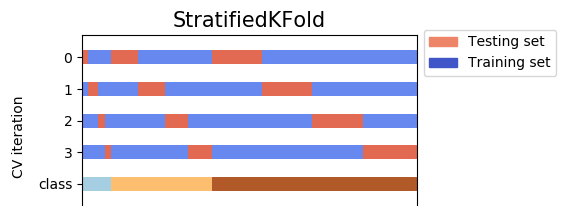
여기서 다루는 자동차 이미지 분류의 경우
그림에서 

1.Class수가 196개로,

2.Fold를 5개로,

3.Testing Set이라는 명칭 대신 Valid Set로 이해하시면 됩니다.

각 클래스별 훈련데이터의 분포가 다르니 StratifiedKFold를 사용하게 되면 각 클래스 분포에 맞춰서
폴드를 나누게 됩니다. 
(앞쪽에서 살펴본 결과 119번 Class의 경우 84개의 샘플이 존재했고, 136번의 경우 30개의 샘플이 존재.
즉 각 클래스별 샘플 수의 비율을 유지하면서 Fold를 나누기 위함.)


In [ ]:
skf = StratifiedKFold(n_splits=k_folds, random_state=2019)
#skf = KFold(n_splits=k_folds, random_state=2019)

In [ ]:
j = 1
model_xception_names = []
for (train_index, valid_index) in skf.split(
    df_train['img_file'], 
    df_train['class']):

    traindf = df_train.iloc[train_index, :].reset_index()
    validdf = df_train.iloc[valid_index, :].reset_index()

    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (j,k_folds))
    print("=========================================")
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=traindf,
        directory=TRAIN_CROPPED_PATH,
        x_col='img_file',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=2019,
        shuffle=True
        )

    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=validdf,
        directory=TRAIN_CROPPED_PATH,
        x_col='img_file',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=2019,
        shuffle=True
        )

    model_name = model_path + str(j) + '_xception.hdf5'
    model_xception_names.append(model_name)
    
    model_xception = get_model(Xception, IMAGE_SIZE)
    
    try:
        model_xception.load_weights(model_name)
    except:
        pass
        
    history = model_xception.fit_generator(
        train_generator,
        steps_per_epoch=len(traindf.index) / BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=valid_generator,
        validation_steps=len(validdf.index) / BATCH_SIZE,
        verbose=1,
        shuffle=False,
        callbacks = get_callback(model_name, 6)
        )
        
    j+=1

5개의 Fold를 훈련하면서 각 폴드별 Val loss가 가장 작은 model weight를 저장합니다.

훈련이 끝나면 5개의 Weight파일이 생성됩니다.

자원이 되시면 여기에 xception 이외에 다른 사전 훈련 모델을 하나 더 추가하시고, 나중에 그 모델까지 통합하여 앙상블 하셔도 될 듯 합니다.

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='img_file',
    y_col=None,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
xception_prediction = []
for i, name in enumerate(model_xception_names):
    model_xception = get_model(Xception, IMAGE_SIZE)
    model_xception.load_weights(name)
    test_generator.reset()
    pred = model_xception.predict_generator(
        generator=test_generator,
        steps = len(df_test)/BATCH_SIZE,
        verbose=1
    )
    xception_prediction.append(pred)

y_pred_xception = np.mean(xception_prediction, axis=0)

5개의 Fold에서 훈련한 결과들(Weight)를 불러들려서 5번 예측하고 평균.

위에서도 말씀드렸지만 자원이 되시는 분들은 결과 다른 사전훈련 모델을 추가하여 같이 돌리시고,

A모델 5Fold 예측평균 + B모델 5Fold 평균..... 이런식으로 하시면 조금이라도점수가 좋아지지 않을까 합니다.


In [ ]:
preds_class_indices=np.argmax(y_pred_xception, axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_pred = [labels[k] for k in preds_class_indices]

In [ ]:
submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = final_pred
submission.to_csv("submission.csv", index=False)
submission.head()